In [1]:
import xarray as xr
import numpy as np
from geopy import distance

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import cartopy as cy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime as dt
from datetime import timedelta
import requests

This notebook retrieves air pressure information at sea level.   Air pressure is needed to substract from sensor measurements, currently I do not have air pressure measurements.
The forecast is based on  on model data from MEPS (MetCoOp-Ensemble Prediction System) and observations with 1 km resolution.  
The forecast is hourly and relased every 6 hours.  
Threads archive: https://thredds.met.no/thredds/catalog/metpparchive/catalog.html  

In [2]:
#example request - note actual forecast file is > 3 GB, I check the file 6 hours ago since met.no takes some time to upload forecast file to archive from where I download it
now = dt.now() - timedelta(hours = 6)
OPeNDAP_url = f'https://thredds.met.no/thredds/dodsC/metpparchive/{now.year}/{now.month}/{now.day}/met_forecast_1_0km_nordic_{now.strftime("%Y%m%d")}T{int((now.hour//6) * 6)}Z.nc'
print(OPeNDAP_url)
ds =  xr.open_dataset(OPeNDAP_url)
ds

https://thredds.met.no/thredds/dodsC/metpparchive/2024/12/29/met_forecast_1_0km_nordic_20241229T12Z.nc


<xarray.Dataset> Size: 11GB
Dimensions:                                                         (x: 1796,
                                                                     y: 2321,
                                                                     time: 59)
Coordinates:
  * x                                                               (x) float32 7kB ...
  * y                                                               (y) float32 9kB ...
  * time                                                            (time) datetime64[ns] 472B ...
    latitude                                                        (y, x) float32 17MB ...
    longitude                                                       (y, x) float32 17MB ...
Data variables: (12/15)
    projection_lcc                                                  int32 4B ...
    forecast_reference_time                                         datetime64[ns] 8B ...
    altitude                                                        (y, x) float32 17MB ...
    land_area_fraction                                              (y, x) float32 17MB ...
    air_temperature_2m                                              (time, y, x) float32 984MB ...
    precipitation_amount                                            (time, y, x) float32 984MB ...
    ...                                                              ...
    cloud_area_fraction                                             (time, y, x) float32 984MB ...
    air_pressure_at_sea_level                                       (time, y, x) float32 984MB ...
    integral_of_surface_downwelling_longwave_flux_in_air_wrt_time   (time, y, x) float32 984MB ...
    integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time  (time, y, x) float32 984MB ...
    relative_humidity_2m                                            (time, y, x) float32 984MB ...
    probability_of_snow_phase                                       (time, y, x) float32 984MB ...
Attributes: (12/14)
    Conventions:                     CF-1.0
    institution:                     Norwegian Meteorological Institute, met.no
    creator_url:                     met.no
    geospatial_lat_min:              51.0
    geospatial_lat_max:              88.0
    geospatial_lon_min:              -20.0
    ...                              ...
    source:                          meps
    summary:                         Based on model data from MEPS (MetCoOp-E...
    meps_forecast_reference_time:    1735462800
    history:                         Created 2024-12-29T12:23:56Z
    license:                         https://www.met.no/en/free-meteorologica...
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
def find_xy_indices(ds,target_lon, target_lat):
    ''' find x and y indixecs to 2d matrices: ds.latitude and ds.longitude for wich distance beween target point and grid point is the smallest'''
    lon_distance = np.abs(ds.longitude - target_lon)
    lat_distance = np.abs(ds.latitude - target_lat)
    # np.maximum is not np.max: Compare two arrays and return a new array containing the element-wise maxima. 
    # calculate  Chebyshev distance matrix - containing distances from target point to all other grid points 
    Chebyshev_dist_matrix = np.maximum(lon_distance,lat_distance)
    return np.where(Chebyshev_dist_matrix == np.min(Chebyshev_dist_matrix))

# area of interest coordinates
min_lon, max_lon = 9.6, 10.5
min_lat, max_lat = 58.8, 59.2
# I am interested in Saltstein beach
salt_lon, salt_lat = 9.850742, 58.965394
salt_coord = (salt_lon, salt_lat)
salt_x, salt_y = find_xy_indices(ds,salt_lon, salt_lat)
salt_grid_coord = ( ds.longitude[salt_x, salt_y].values[0,0], ds.latitude[salt_x, salt_y].values[0,0])
dist_to_nearest_gridpoint = distance.distance(salt_coord,salt_grid_coord)
# distance from point of interest to the nearest grid point, in km
dist_to_nearest_gridpoint.km

0.33154164801838193

In [4]:
dist_to_nearest_gridpoint.km

0.33154164801838193

In [5]:
# air pressure at Saltstein beach
ds['air_pressure_at_sea_level'].isel(time = 0, x = salt_x, y = salt_y).values[0,0]/100

1010.19546875

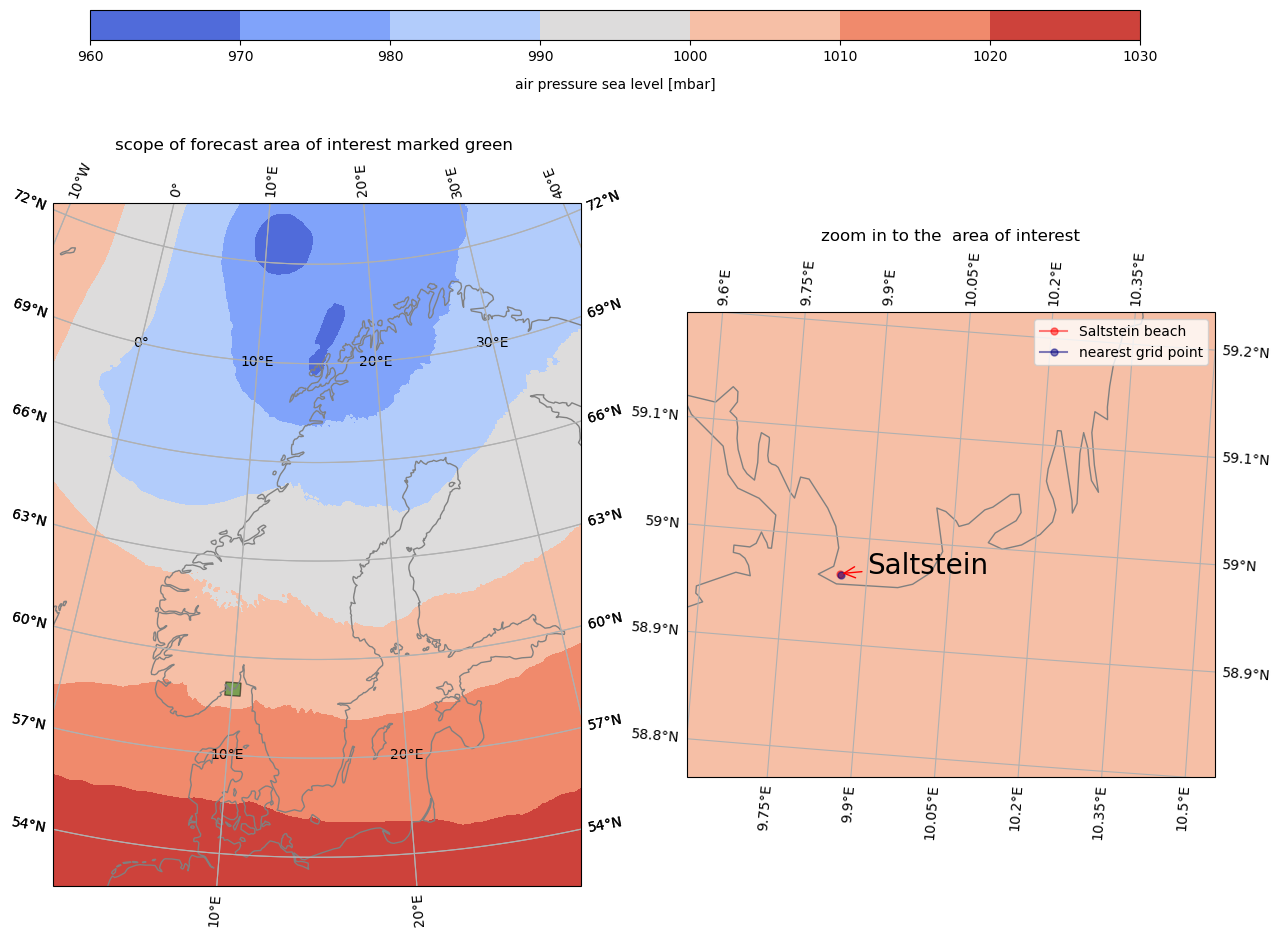

In [6]:
# not sure about projection, there is no info, used from other forecast done by met.no
lcc_projection = ccrs.LambertConformal(central_latitude=63, central_longitude=15, standard_parallels=(63, 63))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10),  subplot_kw={'projection': lcc_projection})
air_pressure = ds.isel(time=0)['air_pressure_at_sea_level']/100 # scale to mbars
pressure_contour = ax1.contourf(ds.x, ds.y, air_pressure, cmap='coolwarm')
ax1.gridlines(draw_labels=True)
ax1.coastlines(resolution='50m', color = 'grey')
ax1.set_title("scope of forecast area of interest marked green ")
ax1.add_patch(mpatches.Rectangle(xy=[min_lon, min_lat], width=(max_lon - min_lon), height=(max_lat - min_lat),
                                facecolor='green', edgecolor='black', alpha = 0.5,
                                transform=ccrs.PlateCarree()))
gridlines1 = ax1.gridlines(draw_labels=True)
gridlines1.x_inline = False

#area of interest
ax2.axes.set_extent([min_lon, max_lon, min_lat, max_lat])
ax2.set_title("zoom in to the  area of interest")
ax2.contourf(ds.x, ds.y, air_pressure, cmap='coolwarm')
ax2.coastlines(resolution='10m', color = 'grey')

gridlines2 = ax2.gridlines(draw_labels=True)
gridlines2.x_inline = False

ax2.plot(salt_lon, salt_lat, marker='o', color='red', alpha = 0.5, markersize=5, label="Saltstein beach", transform=ccrs.PlateCarree())
ax2.plot(salt_grid_coord[0], salt_grid_coord[1], marker='o', color='navy', alpha = 0.5, markersize=5, label="nearest grid point", transform=ccrs.PlateCarree())
ax2.annotate(
    "Saltstein", 
    xy=salt_coord, 
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2),
    xytext=(20, 0),  #
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", color='red'),
    fontsize=20,
    color='black')
ax2.legend()

cbar_ax = fig.add_axes([0.15, 1, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(pressure_contour, cax=cbar_ax, orientation='horizontal')
cbar.set_label('air pressure sea level [mbar]',  labelpad=10)